In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.10'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['XLA_FLAGS']='--xla_gpu_strict_conv_algorithm_picker=false'
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu'
from layers import *
from jax import numpy as np, random, tree_util
from flax import linen as nn
import optax
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from base import ModelInstance
import utils
from framework import test_model

2022-12-20 12:49:37.004523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu
2022-12-20 12:49:37.004604: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu
2022-12-20 12:49:37.004609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/home/trent/anaconda3/envs/python3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidg

In [3]:
for string in tfds.list_builders():
    if string.find('cifar') != -1:
        print(string)

2022-12-20 12:49:38.359611: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


cifar10
cifar100
cifar100_n
cifar10_1
cifar10_corrupted
cifar10_n
huggingface:cifar10
huggingface:cifar100


In [4]:
cifar10 = tfds.builder('cifar10')
cifar10.download_and_prepare()
dataset = cifar10.as_dataset()

2022-12-20 12:49:39.256017: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
class_names = cifar10.info.features['label'].names

In [6]:
tmp = next(iter(dataset['train'].batch(8)))

2022-12-20 12:49:39.541374: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
tmp['image'].shape

TensorShape([8, 32, 32, 3])

/tmp/ipykernel_20434/4171213364.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


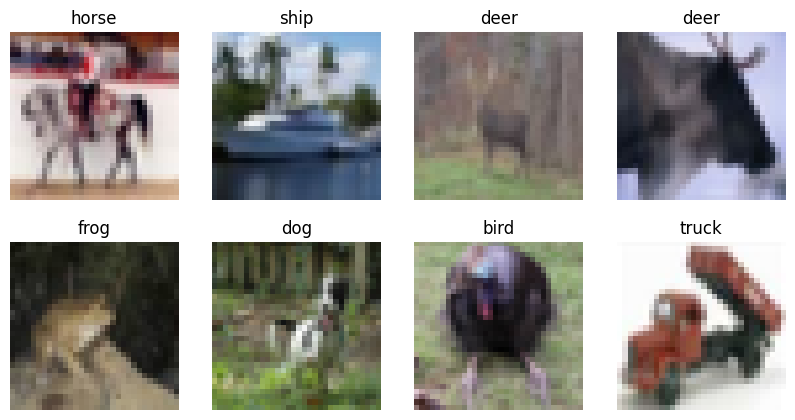

In [8]:
fig = plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.axis('off')
    plt.imshow(tmp['image'][i])
    plt.title(class_names[tmp['label'][i]])
fig.show()

In [9]:
all_data_train = next(iter(dataset['train'].batch(len(dataset['train']))))
X_train = jnp.array(all_data_train['image'])
y_train = jnp.array(all_data_train['label'])
del all_data_train
del dataset
del cifar10

print(X_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000,)


In [10]:
ssc_classifier = nn.Sequential((
        # featurizer
        ConvSSC(case_count=10, features=4, kernel_size=(3,)),
        lambda x: nn.max_pool(x, (2, 2), (2, 2)),
        ConvSSC(case_count=10, features=4, kernel_size=(3,)),
        lambda x: nn.max_pool(x, (2, 2), (2, 2)),
        ConvSSC(case_count=10, features=4, kernel_size=(3,)),
        lambda x: nn.max_pool(x, (2, 2), (2, 2)),
        jax.vmap(lambda x: x.flatten(), 0, 0),
        
        # classifier
        nn.Dense(16),
        nn.relu,
        nn.Dense(16),
        nn.relu,
        nn.Dense(16),
        nn.relu,
        nn.Dense(10)
))

In [11]:
test_model(ssc_classifier, X_train, y_train,
           loss_fn=optax.softmax_cross_entropy_with_integer_labels, need_vmap=True,
           optimizer=optax.adam(1e-3), num_epochs=5, batch_size=32, test_size=0.2)

parameter count: 3554


iteration 20: train_loss:  1.65e+01, val_loss:  1.70e+01: : 21it [01:06,  3.15s/it]
epoch 0: val_loss:  6.61e+01:   0%|          | 0/5 [01:10<?, ?it/s]


KeyboardInterrupt: 